In [1]:
# Initial setup
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline




In [2]:
# Adjust size of figures so they are easier to see
from matplotlib import rcParams
rcParams.update({'font.size': 14, 'figure.figsize': (10, 5)})


# CMB angular power spectrum

In this notebook, we will analyze simulated CMB temperature maps to find their angular power spectrum. In class we discussed the definition of the CMB power spectrum, 

$$
\begin{equation}
C_\ell = \left\langle a_{\ell m} a_{\ell m}^* \right\rangle ,
\end{equation}
$$

where $a_{\ell m}$ are coefficients for the spherical harmonic transform of the temperature anisotropy map,

$$
\begin{equation}
\delta T (\theta,\phi) = \sum_{\ell=0}^\infty \sum_{m=-\ell}^\ell a_{\ell m} Y_{\ell m} (\theta,\phi) .
\end{equation}
$$

##l is called the multipole and represents a given angular scale in the sky α, given approximately by α = π/l (in degrees). The CMB has a mean temperature of Tγ = 2.7255 ± 0.0006 K (1σ), which can be considered as the monopole component (l = 0) of CMB maps, a00. Since all mapping experiments involve difference measurements, they are insensitive to this average level. The largest anisotropy (directionally dependent) is the dipole (l = 1), the first spherical harmonic, with amplitude 3.355±0.008mK. The dipole is interpreted to be the result of the Doppler shift caused by the solar system motion relative to the nearly isotropic blackbody field. The variations in the CMB temperature maps at higher multipoles (l ≥ 2) are interpreted as being mostly the result of perturbations in the density of the early Universe, manifesting themselves at the epoch of the last scattering of the CMB photons.


For this exercise, we are going to consider only a small region of sky, 20 degrees on a side. This region is small enough that we can approximate it as flat and use a two-dimensional Fourier transform instead of a spherical harmonic transform (this is much easier and faster!). 


## Simulated CMB temperature map

First, we will load a [file](CMB_TT.dat) that contains a theoretical CMB temperature power spectrum for standard cosmology. **Make a plot of this power spectrum.** Note that the $\ell=0$ (monopole) and $\ell=1$ (dipole) terms have been set explicitly to zero ##to determine the absolute rest frame. 

Text(0, 0.5, '$D_{\\ell}$')

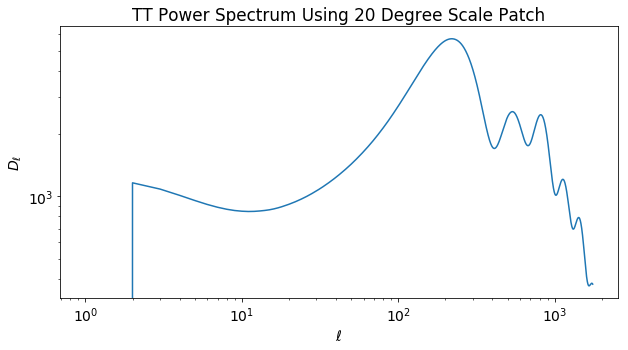

In [12]:
# Load CMB theory spectrum from file
cmb_theory = np.genfromtxt('CMB_TT.dat')
# Column 0 : ell, Column 1 : TT spectrum
ell = cmb_theory[:,0]
Dl = cmb_theory[:,1]

# Make a plot of the CMB TT power spectrum
plt.loglog(ell,Dl)
plt.title('TT Power Spectrum Using 20 Degree Scale Patch')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}$')


I have provided some code that will randomly generate a CMB temperature map from a specified power spectrum, which you will import from the [phys4026_cmb module](phys4026_cmb.py). 

The map generated by this code covers 20 x 20 degrees and has 512 x 512 pixels, so each pixel is roughly 2.3 arc-minutes square.

1. Use the **generate_cmb** function (from phys4026_cmb module) to create a simulated CMB temperature map
2. Use the [**plt.imshow**](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html) function to draw your map. This function just treats a two-dimensional array of data as an image. You need to use the **extent** keyword so that the x and y axes are in units of degrees. Use **plt.xlabel** and **plt.ylabel** to label your axes. Add a color scale using **plt.colorbar**.


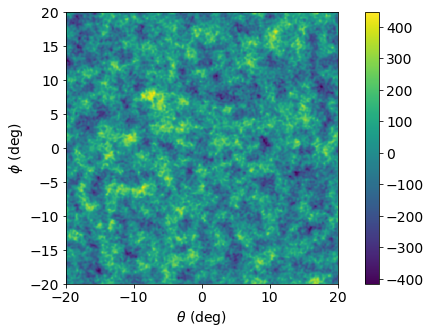

In [4]:
# Import generate_cmb function from phys4026_cmb module
from phys4026_cmb import generate_cmb

# Generate simulated CMB temperature map
temp_map = generate_cmb(Dl)

# Use help(generate_cmb) to get information on how to use this function.

# Draw CMB temperature map using plt.imshow
plt.imshow(temp_map,extent=(-20,20,-20,20))
plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'$\phi$ (deg)')
plt.colorbar()

## Angular power spectrum

Now we will try to calculate the angular power spectrum of the temperature map, #which gives the amplitude as a function of wavelength. As mentioned above, we will be using a two-dimensional Fourier transform, instead of spherical harmonics.

The Fourier transform converts a function into a sum of sinusoids. In one dimension, this can be written

$$
\begin{equation}
f(x) = \sum_k a(k) \exp ( \imath k x ) ,
\end{equation}
$$

where $k$ are wave numbers ($k = 2 \pi / \lambda$) and $a(k)$ are the Fourier coefficients. 

For a two-dimensional Fourier transform, we need to include wave numbers for both the x and y directions.

$$
\begin{equation}
f(x, y) = \sum_{k_x} \sum_{k_y} a(k_x,k_y) \exp [ \imath ( k_x x + k_y y ) ]
\end{equation}
$$

To make this look more like spherical harmonics, we can replace $k_x$ and $k_y$ with $\ell_x$ and $\ell_y$, then $\ell = \sqrt{\ell_x^2 + \ell_y^2}$. Note that you will only get the correct $\ell$ values if you work in angular units of *radians*.

We are working with data in discrete pixels $f_{i,j}$, not a continuous function $f(x,y)$. This has some consequences for a *discrete Fourier transform*:

* The longest wavelength that can be measured is equal to the size of the map, which is 20 degrees in our case. 20 degrees = 0.35 radians, so the smallest $\ell$ value we can obtain in our map is $\ell_\mathrm{min} = 2 \pi / 0.35 = 18$.
* The shortest wavelength that can be measured is two times the pixel size. Each pixel in our map is 20 / 512 = 0.04 degrees = 0.00068 radians, so the largest $\ell$ value we can measure is $\ell_\mathrm{max} = 2 \pi / (2 * 0.00068) = 4608$. (But the theoretical CMB spectrum that we used to generate our map only went up to $\ell = 1750$, so our map doesn't contain any signal beyond that scale.)

If we start with a 512 x 512 map, the 2d Fourier transform will also be a 512 x 512 array defined on an $(\ell_x, \ell_y)$ grid that extends from $-\ell_\mathrm{max}$ to $+\ell_\mathrm{max}$ in steps of $\ell_\mathrm{min}$. As a first step, write a function that calculates the Fourier space coordinate grid. Most of this is already written, but you need to add lines to calculate $\ell_\mathrm{min}$ and $\ell_\mathrm{max}$. Also, check to make sure that you understand the code.


In [5]:
def fourier_grid(npix=512, map_size=np.radians(20.0)):
    """
    Calculates ell_x and ell_y coordinates in Fourier space.
    
    Inputs
    ------
    npix : int, optional
        Number of pixels for the x and y axes of the map (assume square map). Default is 512.
    map_size : float
        Width of the map in radians. Default is 0.35 radians (20 degrees).
    
    Returns
    -------
    lx : array, shape=(npix, npix)
        Two-dimensional array of ell_x values
    ly : array, shape=(npix, npix)
        Two-dimensional array of ell_y values
    
    """
    
     # Calculate lmin and lmax values, as described above.
    ##### NEED TO ADD CODE HERE #####
    lmin = 18
    lmax = 4608
    # We can use the np.linspace function to create an array of numbers that goes from -1 to +1 in npix steps.
    N = np.linspace(-1, 1, num=npix)
    # Now, stretch this array so it extends from -lmax to +lmax
    N = N * lmax
    # Create a two-dimensional (npix x npix) array for lx by repeating this on every row.
    # Can do this quickly by taking outer product with an array of ones.
    lx = np.outer(np.ones(npix), N)
    # For a square array, the ly values are just the transpose of the lx values, i.e. repeat N on columns 
    # instead of rows or use np.transpose take take the transpose of lx.
    ly = np.transpose(lx)
    # Done
    return (lx, ly)
    

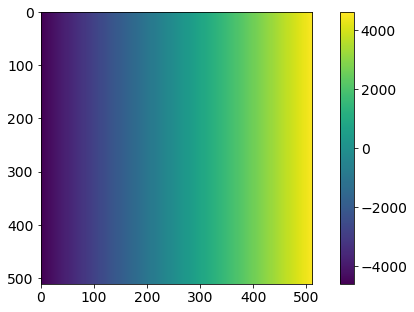

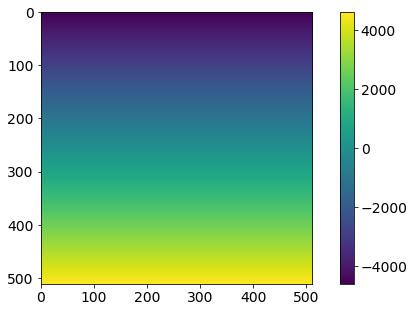

In [6]:
# Try plotting lx and ly using plt.imshow to check that you are getting the right behavior.
# The grid should be from 0 to 512 pixels in the x and y directions. 
# If you include a color bar, it should go from -lmax,lmax (-4608,4608) 

array_fourier = np.array(fourier_grid())
plt.imshow(array_fourier[0,:,:])
plt.colorbar()
plt.figure()
plt.imshow(array_fourier[1,:,:])
plt.colorbar()

Now we are ready to take the 2d Fourier transform of our map. This can be done using the function [**np.fft.fft2**](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.fft.fft2.html). 

One thing to be aware of with Fourier transforms is that there are several different conventions for normalization. To get the correct results in your power spectrum calculation, you should divide the values in the Fourier map by $\pi$ times the total number of pixels (i.e. $\pi \times 512^2$, unless you changed `npix`).

Also, **np.fft.fft2** gives you the Fourier transform with an odd arrangement that won't match the fourier_grid function that is written above. To fix this, you should include a line in this function to apply [**np.fft.fftshift**](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.fft.fftshift.html#numpy.fft.fftshift) to the transform before you return it.

In [7]:
def fourier_transform(Tmap):
    """
    Calculates the two-dimensional Fourier transform of a map
    
    Inputs
    ------
    Tmap : array, size=(npix, npix)
        Input map to be transformed
        
    Returns
    -------
    fmap : array, size=(npix, npix)
        Fourier transform of input map
    
    """
    fourier_tmap = np.fft.fft2(Tmap)
    normed_map = fourier_tmap/(np.pi*512**2)
    shifted_map = np.fft.fftshift(normed_map)
    return shifted_map 

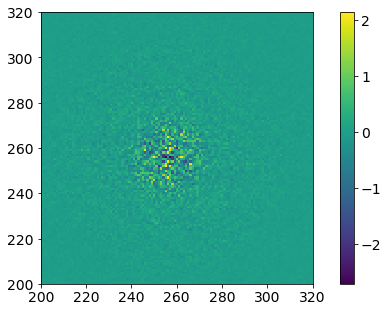

In [8]:
# Now use your defined function to do a fourier transform on temp_map.
# Try plotting the Fourier transform of your map using plt.imshow
# The Fourier transform is complex-valued, so you should try plotting either the absolute value (use np.abs)
# or the real part (use np.real).
# Remember that the Fourier map extends over lx, ly = -4608 to +4608 but most of the signal will be in close
# to the origin. You can use plt.xlim and plt.ylim to adjust the limits of your plot to focus on the 
# interesting region.

np.shape(Dl)
fourier_tmap = fourier_transform(temp_map)
plt.imshow(np.real(fourier_tmap))
plt.xlim([200,320])
plt.ylim([200,320])
plt.colorbar()

The two functions that you wrote above provide you with the Fourier transform of your map as well as the $(\ell_x, \ell_y)$ coordinates for each point. Use these arrays to calculate the CMB angular power spectrum by following these steps:

1. From $(\ell_x, \ell_y)$ calculate a radial coordinate $\ell = \sqrt{\ell_x^2 + \ell_y^2}$. This will tell you the $\ell$ value, or angular scale, for each point in the Fourier transform.
2. We can't measure the power spectrum at every single $\ell$ with just a 20 deg x 20 deg map, so it is necessary to group together nearby $\ell$ values into bins. I suggest using bins with width of 40, so the bin 0 would contain all the points with $\ell \in [0,39]$, bin 1 contains points with $\ell \in [40,79]$, etc. Define your bins and then calculate the bin number corresponding to all of the $\ell$ values that you found in step 1. It is not necessary to extend your bins past $\ell = 1500$ or so.
3. Now for each bin, select the Fourier map values for all of the grid points that fall into that bin, take their absolute square, i.e. `np.abs(...)**2` (which is mathematically equivalent to $a a^*$), and average them. That is your $\mathcal{C}_\ell$ value for this bin.

In [17]:
def angular_power_spectrum(lx, ly, fmap, binwidth=40.0, lmax=1500.0):
    """
    Calculate binned angular power spectrum from a Fourier map
    
    Inputs
    ------
    lx : array, shape=(npix, npix)
        2d array of ell_x values
    ly : array, shape=(npix, npix)
        2d array of ell_y values
    fmap : array, shape=(npix, npix)
        2d Fourier transform of CMB map
    binwidth : float, optional
        Width for ell bins. Default value is 40.
    lmax : float, optional
        Highest ell bin to calculate. Default value is 1500.
    
    Returns
    -------
    Cl : array, shape=(nbin)
        CMB angular power spectrum
    
    """
    
    # 1. Calculate radial coordinate from lx, ly
    ell_values = np.sqrt(lx**2 + ly**2)
    
        
        
    # 2. Use that calculated radial coordinate to figure out which ell bin each point belongs to
    #    Here is some code to get calculate the edges of the ell bins, but you need to do the rest.
    bin_edge = np.arange(0, lmax, binwidth)
    binned_fmap = np.zeros([len(bin_edge)-1])
    binsize= np.zeros([len(bin_edge)])
    for q in range(len(binned_fmap)):
        x=(ell_values>=bin_edge[q])&(ell_values<bin_edge[q+1])
        binned_fmap[q]=np.mean(np.abs(fmap[x])**2)
    return binned_fmap
                
                                
    
    
    # 3. Calculate Cl by averaging the absolute-square of the points belonging to each bin
    #    I have started by creating an empty array and looping over bins, but you need to do the rest.
    
    

In [ ]:
# Calculate the angular power spectrum of your map.
# Plot it and compare to the input angular power spectrum.
# Don't forget that your angular_power_spectrum function calculates C_ell but the input spectrum was D_ell.
# The difference is D_ell = ell * (ell + 1) * C_ell / (2 * pi)


In [18]:
pspec = angular_power_spectrum(array_fourier[0,:,:],array_fourier[1,:,:],fourier_tmap)

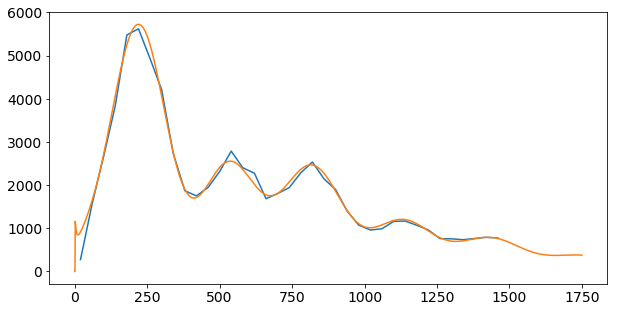

In [23]:

bin_edge = np.arange(0, 1500, 40)
l = (bin_edge[0:-1]+20)
plt.plot(l, pspec*l*(l+1)/2/np.pi)
plt.plot(ell,Dl)